# Sentiment Analysis and Evaluative Language

### Implementation for German Dataset

In [1]:
import gensim
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.similarities import Similarity

import numpy as np
import pandas as pd
from scipy import spatial

import ast
import csv
import io
import glob
import spacy
import re
import string
import random
from random import sample
from itertools import chain
import pickle

import spacy
import nltk

from collections import Counter
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AffinityPropagation

from textblob_de import TextBlobDE as TextBlob

from itertools import cycle
from joblib import Parallel, delayed

C:\Users\Brottrager\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Sentiment Analysis

In [2]:
def tokenize_pipe(doc):
    tok_list = [tok.text.lower() for tok in doc
                  if tok.is_alpha] 
    return tok_list

def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=8):
        preproc_pipe.append(tokenize_pipe(doc))
    return preproc_pipe

In [3]:
nlp = spacy.load('de_core_news_sm')
nlp.max_length = 1000000000

#### Reviews: Data import and preprocessing

In [4]:
reviews_eng = r"C:\Users\Brottrager\Documents\Diss\reviews\GER_reviews"
additional_text = r"C:\Users\Brottrager\Documents\Diss\reviews\GER_corpus"

In [5]:
list_files = glob.glob(reviews_eng + '/*.txt')
list_additional = glob.glob(additional_text + '/*.txt')

In [6]:
reviews_txt = []
for file_path in list_files:
    with open(file_path, encoding="UTF-8") as file:
        reviews_txt.append(file.read())
        
additional_txt = []
for file_path in list_additional:
    with open(file_path, encoding="UTF-8") as file:
        additional_txt.append(file.read())

In [7]:
reviews_txt_clean = [word.replace('\n',' ') for word in reviews_txt]
reviews_txt_clean = [word.lower() for word in reviews_txt_clean]

#reviews = preprocess_pipe(reviews_txt_clean)

#with open(r'C:\...\GER_reviews_tok.pkl', 'wb') as f:
#    pickle.dump(reviews, f)

In [8]:
with open(r'C:\Users\Brottrager\Documents\Diss\reviews\pickled\GER_reviews_tok.pkl', 'rb') as f:
    reviews = pickle.load(f)

In [9]:
reviews_toks = [tok for sent in reviews for tok in sent]

In [10]:
df_fdist_reviews = pd.DataFrame(reviews_toks, columns=['Freq'])
relfreq_reviews = pd.DataFrame(df_fdist_reviews['Freq'].value_counts(normalize=True))

#### Comparative corpus: Data import and preprocessing

In [11]:
#additional_txt_clean = [word.replace('\n',' ') for word in additional_txt]
#additional_txt_clean = [word.lower() for word in additional_txt_clean]

#additional = preprocess_pipe(additional_shuffled)

#with open(r'C:...\GER_additional_lemma.pkl', 'wb') as f:
#    pickle.dump(additional_ger, f)

In [12]:
with open(r'C:\Users\Brottrager\Documents\Diss\reviews\pickled\GER_additional_tok.pkl', 'rb') as f:
    additional = pickle.load(f)

In [13]:
additional_toks = [tok for sent in additional for tok in sent]

In [14]:
df_fdist_additional = pd.DataFrame(additional_toks, columns=['Freq'])
relfreq_additional = pd.DataFrame(df_fdist_additional['Freq'].value_counts(normalize=True))

#### Comparative frequency

In [15]:
in_novels = []
in_reviews = []
for row in relfreq_reviews.index:
    freq_reviews = float(relfreq_reviews.loc[row])
    freq_additional = 0
    if row in relfreq_additional.index:
        freq_additional = float(relfreq_additional.loc[row])
    score = freq_reviews-freq_additional
    #print(row + ": " + str(freq_reviews) + " | " + str(freq_additional)) 
    if score > 0:
        in_reviews.append([row, score])
    else:
        in_novels.append([row, score])

In [16]:
in_reviews_words = []
for entry in in_reviews:
    in_reviews_words.append(entry[0])

#### Word embedding

In [17]:
#all_toks = additional_toks + reviews_toks
#sents = additional + reviews
#model = Word2Vec(sentences = sents, vector_size=300, window=5, min_count=1, workers=4)

#with open(r'C:\...\GER_reviews_model_FINAL.pkl', 'wb') as f:
#    pickle.dump(model, f)

In [18]:
with open(r'C:\Users\Brottrager\Documents\Diss\reviews\pickled\GER_reviews_model_FINAL.pkl', 'rb') as f:
    model = pickle.load(f)

#### Evaluative words

In [19]:
pos = ["ADJ","NOUN"]
reviews_pos = []
for doc in nlp.pipe(reviews_txt_clean, disable=["ner"]):
    sentence_lemmas = [[token.lemma_ for token in sent if token.pos_ in pos] for sent in doc.sents]
    reviews_pos = reviews_pos + sentence_lemmas

In [20]:
stopwords = nltk.corpus.stopwords.words("german")

In [21]:
reviews_tok_clean = [[tok for tok in review if tok not in stopwords] for review in reviews_pos]

In [22]:
reviews_toks = []
for review in reviews_tok_clean:
    for tok in review:
        if tok in in_reviews_words:
            reviews_toks.append(tok)

In [23]:
reviews_tok_clean_top = Counter(reviews_toks).most_common(10000)
corpus_top = [i[0] for i in reviews_tok_clean_top]

In [24]:
pos = ["anziehend","genial","geistreich","angemessen",
       "wahr","poetisch","gelungen","ästhetisch",
       "originell","künstlerisch","edel",
       "großartig","dichterisch","meisterhaft","wertvoll",
       "tadellos","wahrhaft","ideal","echt","hervorragend"]

In [25]:
len(pos)

20

In [26]:
add_pos = []
for p in pos:
    x = model.wv.most_similar(p, topn=10)
    for entry in x:
        add_pos.append(entry[0])

In [27]:
neg = ["misform","überspannt","dürftig","seltsam",
      "schädlich","unfertig","frech","enttäuschung",
      "schwäche","tadel","simpel","übertrieben","überflüssig",
      "fehler","niedrig","grauenhaft","umständlich","oberflächlich",
      "mittelmäßig","unnatürlich"]

In [28]:
len(neg)

20

In [29]:
add_neg = []
for p in neg:
    x = model.wv.most_similar(p, topn=10)
    for entry in x:
        add_neg.append(entry[0])

In [30]:
val_words = pos + neg + add_pos + add_neg
val_words = list(set(val_words))

In [31]:
remaining_words = []
for word in val_words:
    if word in corpus_top:
        remaining_words.append(word)

In [32]:
len(remaining_words)

105

#### Review analysis / SentiArt

In [33]:
l = []
for word in remaining_words:
    l.append(model.wv[word])
X = np.array(l)

In [34]:
af = AffinityPropagation(random_state=1).fit(X)

In [35]:
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

In [36]:
n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)

Estimated number of clusters: 21


In [37]:
cluster_words = [""]*len(cluster_centers_indices)
i = 0

for label in labels:
    cluster_num = int(label)
    cluster_words[cluster_num] = cluster_words[cluster_num] + " " + remaining_words[i]
    i += 1

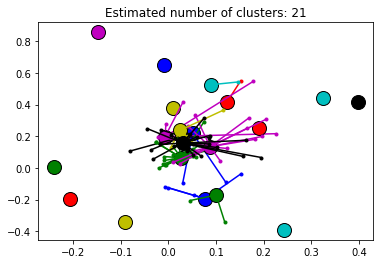

In [38]:
plt.close("all")
plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
        )
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [39]:
cluster_words

[' annäherung behauptung dummheit enttäuschung bezeichnung',
 ' fehler',
 ' zart edel',
 ' gelungen unbekannt',
 ' fein',
 ' einfach',
 ' wahrhaft',
 ' vorzüge gesinnung kenntnisse',
 ' schwäche existenz erfindung',
 ' beweis',
 ' bedeutung',
 ' lächerlich langweilig interessant billig allgemein',
 ' erfolg',
 ' schwächen enthusiasmus spott tadel aberglauben',
 ' scharf',
 ' blasirt grauenhaft fruchtbar bündner einseitig meisterhaft altmodisch künstlerisch tnige unwahrscheinlich temperatur genial störend moralisch naturschilderungen prachtvoll romantisch simpel durchgedroschenen lebensanschauung dichterisch historisch naivetät ästhetisch unnatürlich klassisch schen oberflächlich überspannt holländisch',
 ' eigenschaften',
 ' ideal',
 ' komisch überflüssig auffallend echte unbedingt bedeutend echt vornehm gerecht selbstverständlich reizend geistig trefflich berühmt',
 ' system kunstwerk meisterstück eigenthum vorbild',
 ' dürftig poetisch phantastisch scharfsinn lächerliche anziehend zu

In [40]:
#Check indeces and adapt if necessary
pos_centroids = [X[cluster_centers_indices[14]]]

' meisterstück system vorbild eigenthum kunstwerk',

In [41]:
#Check indeces and adapt if necessary
neg_centroids = [X[cluster_centers_indices[15]]]

' billig allgemein interessant langweilig lächerlich',

In [42]:
similarity = []
all_pos = []
all_neg = []
for word in corpus_top:
    vec = model.wv[word]
    
    pos = 0
    for centroid in pos_centroids:
        pos = np.dot(centroid, vec)/(np.linalg.norm(centroid)* np.linalg.norm(vec))
        all_pos.append(pos)
    pos = pos/len(pos_centroids)
    
    neg = 0
    for centroid in neg_centroids:
        neg = np.dot(centroid, vec)/(np.linalg.norm(centroid)* np.linalg.norm(vec))
        all_neg.append(neg)
    neg = neg/len(neg_centroids)
    
    sim = pos-neg
    similarity.append(sim)

In [43]:
senti_dict = dict(zip(corpus_top,similarity))

In [44]:
senti_dict

{'zeit': -0.11904947459697723,
 'geschichte': -0.25481847673654556,
 'deutsch': -0.1526808738708496,
 'ganze': -0.12660668790340424,
 'romans': -0.27063271403312683,
 'dichter': -0.19459684193134308,
 'neu': -0.14518260955810547,
 'recht': 0.10175372660160065,
 'buch': -0.06873562932014465,
 'erzählung': -0.22812272608280182,
 'werk': -0.18014805018901825,
 'verfasser': -0.32689762115478516,
 'eigen': -0.15950456261634827,
 'letzt': -0.2125038206577301,
 'novelle': -0.3868241012096405,
 'schöne': -0.02964457869529724,
 'darstellung': -0.38116052746772766,
 'kunst': -0.3585652399342507,
 'junge': 0.05391301214694977,
 'poesie': -0.41731390357017517,
 'personen': -0.3067234084010124,
 'allgemein': -0.2671465575695038,
 'ende': -0.07268505543470383,
 'geliebt': -0.09351950883865356,
 'tochter': -0.0319291353225708,
 'helden': -0.3181333988904953,
 'welt': -0.10271679610013962,
 'seite': 0.1554630696773529,
 'neue': -0.26275642216205597,
 'seiten': 0.07280391454696655,
 'form': -0.37025508

In [45]:
reviews_toks = []
for doc in nlp.pipe(reviews_txt_clean, disable=["ner"]):
    sentence_toks = [[token.lemma_ for token in sent if token.text not in stopwords and token.is_alpha] for sent in doc.sents]
    reviews_toks.append(sentence_toks)

In [46]:
reviews_sentiscores = []
for review in reviews_toks:
    sentiscores_review_level = []
    sentence_count = 0
    
    for sentence in review:
        sentiscores_sent_level = []
        
        for word in sentence:
            if word in senti_dict.keys():
                score = senti_dict[word]
                sentiscores_sent_level.append(score)
                
        if len(sentiscores_sent_level) != 0:
            sentiscores_review_level.append(sum(sentiscores_sent_level)/len(sentiscores_sent_level))
        else:
            sentiscores_review_level.append(0)
    
    if len(sentiscores_review_level) != 0:
        reviews_sentiscores.append(sum(sentiscores_review_level)/len(sentiscores_review_level))
    else:
        reviews_sentiscores.append(0)

#### Comparison: Sentiment analysis with TextBlob

In [47]:
all_sentiment_scores = []
for review in reviews_toks:
    sentiscores_review_level = []
    sentence_count = 0
    
    for sentence in review:
        sentiscores_sent_level = []
        
        for word in sentence:
            score = TextBlob(word).sentiment.polarity
            sentiscores_sent_level.append(score)
                
        if len(sentence) != 0:
            sentiscores_review_level.append(sum(sentiscores_sent_level)/len(sentence))
        else:
            sentiscores_review_level.append(0)
        
    if len(review) != 0:
        all_sentiment_scores.append(sum(sentiscores_review_level)/len(review))
    else:
        all_sentiment_scores.append(0)

In [48]:
filenames = []
journals = []
text_ids = []
for file in list_files:
    filename = re.sub(r".+reviews\\(.+).txt", r"\1", file)
    filenames.append(filename)
    journal = re.sub(r"\d{5}_\d{4}_(.+?)_.+", r"\1", filename)
    journals.append(journal)
    text_id = re.sub(r"(\d{5})_.+", r"\1", filename)
    text_ids.append(int(text_id))

In [49]:
reviews_senti_df = pd.DataFrame(
    {'sentiscore_average': reviews_sentiscores,
     'sentiment_Textblob': all_sentiment_scores,
     'textfile': filenames,
     'journal': journals,
     'text_id': text_ids
})

In [50]:
#reviews_senti_df.to_csv(r"C:\Users\Brottrager\Documents\Diss\reviews\results_sentiscores\GER_reviews_senti_FINAL.csv",
#                        sep = ';', encoding = 'utf-8')

In [51]:
testset = pd.read_csv(r'C:\Users\Brottrager\Documents\Diss\reviews\GER_testset.csv', sep = ";")
reviews_senti_df = pd.read_csv(r'C:\Users\Brottrager\Documents\Diss\reviews\results_sentiscores\GER_reviews_senti_FINAL.csv', 
                               sep = ';', encoding = 'utf-8')

In [52]:
eval_df = pd.merge(testset, reviews_senti_df, how='inner', on=['textfile'])

In [53]:
eval_df

,textfile,class,Unnamed: 0,sentiscore_average,sentiment_Textblob,journal,text_id
0,20003_1833_MGS_101,-1,3,0.004623,0.023481,MGS,20003
1,20004_1827_ALZ_205,1,4,0.005824,0.027773,ALZ,20004
2,20055_1888_BLU_830,-1,27,-0.008142,0.009189,BLU,20055
3,20072_1896_BLU_425,-1,35,-0.056917,0.011406,BLU,20072
4,20084_1788_ALZ_606,-1,43,0.033813,-0.024755,ALZ,20084
5,20090_1834_MGS_161,-1,51,-0.121538,0.043750,MGS,20090
6,20102_1883_BLU_682,1,54,-0.031189,0.058796,BLU,20102
7,20103_1890_BLU_468,1,55,-0.022799,0.011651,BLU,20103
8,20109_1898_BLU_826,1,65,-0.029181,0.021284,BLU,20109
9,20113_1879_BLU_131,-1,68,-0.013417,0.026181,BLU,20113


In [54]:
confusion_matrix_sentiscore = [[0], [0], 
                               [0], [0]]
confusion_matrix_sentiscore = pd.DataFrame(confusion_matrix_sentiscore,
                                          index = ['TP','FP','TN','FN'],
                                          columns = ['count'])
confusion_matrix_textblob = [[0], [0], 
                             [0], [0]]
confusion_matrix_textblob = pd.DataFrame(confusion_matrix_textblob,
                                          index = ['TP','FP','TN','FN'],
                                          columns = ['count'])


for index, row in eval_df.iterrows():
    sentiscore = row['sentiscore_average']
    textblob = row['sentiment_Textblob']
    classified = row['class']
    text_id = row['text_id']

    if classified == 1:
        if sentiscore > 0:
            #print(str(text_id )+ ": TRUE POSITIVE: " + str(classified) + " : " + str(sentiscore))
            confusion_matrix_sentiscore.loc["TP"] += 1
        else:
            #print(str(text_id )+ ": FALSE NEGATIVE: " + str(classified) + " : " + str(sentiscore))
            confusion_matrix_sentiscore.loc["FN"] += 1
            
        if textblob > 0:
            #print(str(text_id )+ ": TRUE POSITIVE: " + str(classified) + " : " +  str(textblob))
            confusion_matrix_textblob.loc["TP"] += 1
        else:
            #print(str(text_id )+ ": FALSE NEGATIVE: " + str(classified) + " : " +  str(textblob))
            confusion_matrix_textblob.loc["FN"] += 1
            
    else:
        if sentiscore < 0:
            #print(str(text_id )+ ": TRUE NEGATIVE: " + str(classified) + " : " + str(sentiscore))
            confusion_matrix_sentiscore.loc["TN"] += 1
        else:
            #print(str(text_id )+ ": FALSE POSITIVE: " + str(classified) + " : " + str(sentiscore))
            confusion_matrix_sentiscore.loc["FP"] += 1       

        if textblob < 0:
            #print(str(text_id )+ ": TRUE NEGATIVE: " + str(classified) + " : " + str(textblob))
            confusion_matrix_textblob.loc["TN"] += 1
        else:
            #print(str(text_id )+ ": FALSE POSITIVE: " + str(classified) + " : " + str(textblob))
            confusion_matrix_textblob.loc["FP"] += 1       


In [55]:
confusion_matrix_sentiscore

,count
TP,8
FP,5
TN,10
FN,7


In [56]:
confusion_matrix_textblob

,count
TP,13
FP,9
TN,6
FN,2


In [57]:
tp_senti = int(confusion_matrix_sentiscore.loc["TP"])
tn_senti = int(confusion_matrix_sentiscore.loc["TN"])
fn_senti = int(confusion_matrix_sentiscore.loc["FN"])
fp_senti = int(confusion_matrix_sentiscore.loc["FP"])

recall_senti = tp_senti/(tp_senti + fn_senti)
precision_senti = tp_senti/(tp_senti + fp_senti)
accuracy_senti = (tp_senti + tn_senti) / 30

print("Sentiscore:\n" + 
      "Recall: " + str(recall_senti) + "\n" +
      "Precision: " + str(precision_senti) + "\n" +
      "Accuracy: " + str(accuracy_senti))

Sentiscore:
Recall: 0.5333333333333333
Precision: 0.6153846153846154
Accuracy: 0.6


In [58]:
tp_textblob = int(confusion_matrix_textblob.loc["TP"])
tn_textblob = int(confusion_matrix_textblob.loc["TN"])
fn_textblob = int(confusion_matrix_textblob.loc["FN"])
fp_textblob = int(confusion_matrix_textblob.loc["FP"])

recall_textblob = tp_textblob/(tp_textblob + fn_textblob)
precision_textblob = tp_textblob/(tp_textblob + fp_textblob)
accuracy_textblob = (tp_textblob + tn_textblob) / 30

print("TextBlob:\n" + 
      "Recall: " + str(recall_textblob) + "\n" +
      "Precision: " + str(precision_textblob) + "\n" +
      "Accuracy: " + str(accuracy_textblob))

TextBlob:
Recall: 0.8666666666666667
Precision: 0.5909090909090909
Accuracy: 0.6333333333333333


In [59]:
reviews_senti_df

,Unnamed: 0,sentiscore_average,sentiment_Textblob,textfile,journal,text_id
0,0,-0.001433,0.025530,20000_1843_MGS_401,MGS,20000
1,1,0.005591,0.023794,20001_1853_BLU_558,BLU,20001
2,2,0.024147,-0.034293,20002_1840_MGS_453,MGS,20002
3,3,0.004623,0.023481,20003_1833_MGS_101,MGS,20003
4,4,0.005824,0.027773,20004_1827_ALZ_205,ALZ,20004
...,...,...,...,...,...,...
217,217,-0.019020,0.003717,20538_1791_ALZ_550,ALZ,20538
218,218,-0.006819,0.029328,20538_1796_ALZ_34,ALZ,20538
219,219,0.041336,-0.002568,20543_1818_ALZ_359,ALZ,20543
220,220,0.003864,0.028087,20544_1828_BLU_201,BLU,20544


In [60]:
pos_textBlob = reviews_senti_df.loc[reviews_senti_df['sentiment_Textblob'] > 0]
neg_senti = reviews_senti_df.loc[reviews_senti_df['sentiscore_average'] < 0]

In [61]:
# Define 1st quartile
threshold_textBlob = pos_textBlob['sentiment_Textblob'].describe()[4]
threshold_senti = neg_senti['sentiscore_average'].describe()[4]

In [62]:
pos_textBlob = pos_textBlob.loc[pos_textBlob['sentiment_Textblob'] > threshold_textBlob/2]
neg_senti = neg_senti.loc[neg_senti['sentiscore_average'] < threshold_senti/4]

In [63]:
pos_textBlob_reviews = list(pos_textBlob["textfile"])
neg_senti_reviews = list(neg_senti["textfile"])

In [64]:
pos_textBlob_exclusive = pos_textBlob.loc[~pos_textBlob['textfile'].isin(neg_senti_reviews)]
pos_textBlob_exclusive["classified"] = "positive"
pos_textBlob_exclusive["sentiment"] = pos_textBlob_exclusive["sentiment_Textblob"]
#pos_textBlob_exclusive['sentiscore_average'] = 0

neg_senti_exclusive = neg_senti.loc[~neg_senti['textfile'].isin(pos_textBlob_reviews)]
neg_senti_exclusive["classified"] = "negative"
neg_senti_exclusive["sentiment"] = neg_senti_exclusive["sentiscore_average"]
#neg_senti_exclusive['sentiment_Textblob'] = 0

<ipython-input-64-db5d6bd9f4b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_textBlob_exclusive["classified"] = "positive"
<ipython-input-64-db5d6bd9f4b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_textBlob_exclusive["sentiment"] = pos_textBlob_exclusive["sentiment_Textblob"]
<ipython-input-64-db5d6bd9f4b3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [65]:
pos_textBlob_exclusive_reviews = list(pos_textBlob_exclusive["textfile"])
neg_senti_exclusive_reviews = list(neg_senti_exclusive["textfile"])
not_in = pos_textBlob_exclusive_reviews + neg_senti_exclusive_reviews

not_classified = reviews_senti_df.loc[~reviews_senti_df['textfile'].isin(not_in)]
not_classified["classified"] = "not_classified"
not_classified["sentiment"] = 0

<ipython-input-65-8f6181320c63>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_classified["classified"] = "not_classified"
<ipython-input-65-8f6181320c63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_classified["sentiment"] = 0


In [66]:
dfs = [pos_textBlob_exclusive,neg_senti_exclusive,not_classified]

In [67]:
len(pos_textBlob_exclusive)

89

In [68]:
len(neg_senti_exclusive)

18

In [69]:
reviews_senti_classified = pd.concat(dfs)

In [70]:
reviews_senti_classified

,Unnamed: 0,sentiscore_average,sentiment_Textblob,textfile,journal,text_id,classified,sentiment
0,0,-0.001433,0.025530,20000_1843_MGS_401,MGS,20000,positive,0.025530
1,1,0.005591,0.023794,20001_1853_BLU_558,BLU,20001,positive,0.023794
3,3,0.004623,0.023481,20003_1833_MGS_101,MGS,20003,positive,0.023481
4,4,0.005824,0.027773,20004_1827_ALZ_205,ALZ,20004,positive,0.027773
5,5,-0.006928,0.046649,20005_1826_ALZ_65,ALZ,20005,positive,0.046649
...,...,...,...,...,...,...,...,...
211,211,0.012487,0.005548,20509_1900_DL_1090,DL,20509,not_classified,0.000000
212,212,-0.000574,-0.002262,20515_1849_BLU_1178,BLU,20515,not_classified,0.000000
214,214,-0.017828,0.011840,20534_1835_MGS_435,MGS,20534,not_classified,0.000000
215,215,-0.005489,-0.048849,20537_1845_MGS_420,MGS,20537,not_classified,0.000000


In [71]:
reviews_senti_classified.to_csv(r'C:\Users\Brottrager\Documents\Diss\reviews\results_sentiscores\GER_reviews_senti_classified.csv',
                                sep = ';', encoding = 'utf-8')